In [1]:
%%capture
!pip install ../ opt

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('dark_background')

**Sphere function**
$f(x, y) = x^2 + y^2 \qquad
f(0, 0) = 0 \qquad
-\infty \leqslant x, y \leqslant \infty$

In [3]:
def f1(v):
    return v[0] ** 2 + v[1] ** 2

**Booth's function**
$f(x, y) = (x + 2y - 7)^2 + (2x + y - 5)^2 \qquad
f(1, 3) = 0 \qquad
-10 \leqslant x, y \leqslant 10$

In [4]:
def f2(v):
    return (v[0] + 2 * v[1] - 7) ** 2 + (2 * v[0] + v[1] - 5) ** 2

**Matyas function**
$\\$
$f(x, y) = 0.26 (x^2 + y^2) - 0.48 xy \qquad
f(0, 0) = 0 \qquad
-10 \leqslant x, y \leqslant 10$

In [5]:
def f3(v):
    return 0.26 * (v[0] ** 2 + v[1] ** 2) - 0.48 * v[0] * v[1]

$\displaystyle \nabla f(\boldsymbol{x}) =
\begin{pmatrix} \displaystyle \frac{\partial f}{\partial x_1}\\ \displaystyle \frac{\partial f}{\partial
x_2}\\ \vdots\\ \displaystyle \frac{\partial f}{\partial x_n} \end{pmatrix}$

$\displaystyle {\frac  {\partial f}{\partial x_{k}}}(x_{1},\cdots ,x_{n})=\lim _{{\Delta x\to 0}}{\frac  {f(x_{1},\ldots ,x_{k}+\Delta x,\ldots ,x_{n})-f(x_{1},\ldots ,x_{k},\ldots ,x_{n})}{\Delta x}}.$

In [6]:
delta_x = 1e-6


def derivative(f, v, i):
    upd_v = np.copy(v)
    upd_v[i] += delta_x
    return (f(upd_v) - f(v)) / delta_x


def gradient(f, v):
    return np.array([derivative(f, v, i) for i in range(len(v))])

In [7]:
import functools


def painter_decorator3d(need_picture=None):
    def actual_decorator(func):
        @functools.wraps(func)
        @mpl.rc_context({
            'figure.figsize': (24, 16),
            'figure.facecolor': 'white',
            'figure.dpi': 80,
            'lines.linestyle': '--',
            'legend.fontsize': 0
        })
        def draw(*args, **kwargs):
            if need_picture:
                xk = func(*args, **kwargs)
                function = kwargs.get("f") if kwargs.get("f") else args[0]
                function_name = str(func).split()[1]
                xx = xk[:, 0]
                yy = xk[:, 1]
                zz = function(xk.T)

                lim = max(max(xx), max(yy)) + 2
                x = np.linspace(-lim, lim, 300)
                y = np.linspace(-lim, lim, 300)
                x, y = np.meshgrid(x, y)
                z = function(np.array([x, y]))

                axis_lim = (-lim, 2.5 * lim)
                axis = np.linspace(axis_lim[0], axis_lim[1], 2)
                zeros = np.zeros(2)
                figure = plt.figure(constrained_layout=True)
                figure.suptitle(function_name, color='black', fontsize=15)
                std_view = figure.add_subplot(121, projection='3d')
                std_view.plot_surface(x, y, z, alpha=0.7, cmap='cool')
                std_view.plot(xx, yy, zz, color='white', marker='.')
                std_view.plot(axis, zeros, zeros, color='grey')
                std_view.plot(zeros, axis, zeros, color='grey')
                std_view.scatter([0, axis_lim[1]], [axis_lim[1], 0], [0, 0], color='grey', marker='>', s=45)
                std_view.axis('off')

                upper_view = figure.add_subplot(122, aspect='equal')
                upper_view.contourf(x, y, z, alpha=.7, cmap='cool')
                upper_view.plot(xx, yy, marker='.', color='white')
            return func(*args, **kwargs)

        return draw

    return actual_decorator

In [8]:
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.4f' % x)
from IPython.display import display
from IPython.display import HTML


class Repository(object):
    methods = {}
    id = 0

    @classmethod
    def create(cls, method_name, constant_args, mutable_data, save_data: bool):
        """ Labels assignment """
        if not save_data:
            return

        method_name = f'{method_name}_{cls.id}'
        cls.methods[method_name] = {
            'main': mutable_data,
            'const': constant_args
        }
        cls.id += 1
        return method_name

    @classmethod
    def save(cls, method_name, args, save_data: bool):
        if not save_data:
            return

        """ Saving new method iteration """
        main = cls.methods[method_name]['main']
        for i, arg in enumerate(main.keys()):
            main[arg].append(args[i])

    @classmethod
    def visualize(cls, option='main'):
        """
        Visualize all algorithms results

        option  -- 'all' / 'main' - default
        """
        for method_name, values in cls.methods.items():
            main_info = {
                'method_name': method_name,
                'iterations': len(values['main']['xk']) - 1,
                'x0': [values['main']['xk'][0]],
                'xn': [values['main']['xk'][-1]]
            }
            main_info.update(values['const'])
            main_df = pd.DataFrame(main_info)
            display(HTML(main_df.to_html(index=False)))
            if option == 'all':
                steps_df = pd.DataFrame(values['main'])
                display(HTML(steps_df.to_html(index=False)))

    @classmethod
    def clear(cls):
        cls.methods.clear()

## 1. Gradient descent with constant learning rate

$x_{k+1} = x_k - \lambda \nabla f(x_k), \qquad \lambda = const$

In [9]:
@painter_decorator3d()
def gradient_descent_const(f, x0, learning_rate, tolerance=1e-4, n_iter=1000,
                           save_data=False):
    xk = np.array([x0], dtype=float)
    method_name = Repository.create('gradient_descent_const',
                                    constant_args={
                                        'tolerance': tolerance,
                                        'learning_rate': learning_rate,
                                    },
                                    mutable_data={
                                        'xk': [x0],
                                        'fk': [f(x0)]
                                    },
                                    save_data=save_data)

    for _ in range(n_iter):
        step = learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        xk = np.append(xk, np.array([xk1]), axis=0)
        Repository.save(method_name, [xk1, f(xk1)], save_data)

    return xk

### Optimal learning rate

In [10]:
dummy = gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.2, save_data=True)

### Large learning rate

In [11]:
dummy = gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.9, save_data=True)

### Small learning rate

In [12]:
dummy = gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.01, save_data=True)

## 2. Gradient descent with "step crushing" - метод дробления шага

$\displaystyle f(x_{k+1}) = f(x_k - \lambda_{k}\nabla f(x_k)) \leqslant f(x_k) - \varepsilon \lambda_{k} \| \nabla f(x_k) \|^2, \ \ \displaystyle \varepsilon \in (0, 1)$

$False$: $\lambda_k \rightarrow \frac{\lambda_k}{\delta}, \ \ \delta \in (0, 1)$

In [13]:
from numpy.linalg import norm


@painter_decorator3d()
def gradient_descent_step_crushing(f, x0, learning_rate=1, tolerance=1e-4, n_iter=1000, eps=0.1, delta=0.95,
                                   save_data=False):
    xk = np.array([x0], dtype=float)
    fxk = f(x0)
    i, lr = 0, learning_rate
    method_name = Repository.create('gradient_descent_step_crushing',
                                    constant_args={
                                        'tolerance': tolerance,
                                        'eps': eps,
                                        'delta': delta
                                    },
                                    mutable_data={
                                        'xk': [x0],
                                        'fk': [fxk],
                                        'learning_rates': [learning_rate]
                                    },
                                    save_data=save_data)

    while i < n_iter:
        step = lr * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        fxk1 = f(xk1)
        if fxk1 - fxk > -eps * lr * (norm(gradient(f, xk[-1]), 2) ** 2):
            lr *= delta
            continue

        xk = np.append(xk, np.array([xk1]), axis=0)
        fxk = fxk1
        Repository.save(method_name, [xk1, fxk1, lr], save_data)
        lr = learning_rate
        i += 1

    return xk

In [14]:
dummy = gradient_descent_step_crushing(f2, np.array([10, 10], dtype=float), 1, save_data=True)

## 3. Gradient descent with 1D optimization techniques

$\displaystyle \lambda_k = \arg_{\lambda \in [0, +\inf)} \min \ f(x_k - \lambda \nabla f(x_k))$

In [15]:
from opt_algo.opt_1d import *


@painter_decorator3d()
def gradient_descent_opt1d(f, opt_method, x0, tolerance=1e-4, n_iter=1000,
                           save_data=False):
    xk = np.array([x0], dtype=float)
    l, r = 0, 1e6

    method_name = Repository.create('gradient_descent_opt1d',
                                    constant_args={
                                        'tolerance': tolerance,
                                        'opt_method': str(opt_method).split()[1]
                                    },
                                    mutable_data={
                                        'xk': [x0],
                                        'fk': [f(x0)],
                                        'learning_rates': [0]
                                    },
                                    save_data=save_data)

    for _ in range(n_iter):
        learning_rate = opt_method(lambda lr: f(xk[-1] - lr * gradient(f, xk[-1])), l, r, eps=tolerance)
        step = learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        xk = np.append(xk, np.array([xk1]), axis=0)
        Repository.save(method_name, [xk1, f(xk1), learning_rate], save_data)
    return xk

In [16]:
dummy = gradient_descent_opt1d(f2, golden_section_search, np.array([10, -10], dtype=float), save_data=True)

In [17]:
dummy = gradient_descent_opt1d(f2, fibonacci_search, np.array([10, -10], dtype=float), save_data=True)

## 4. Fletcher-Reeves Method

${\displaystyle
\vec{x}_{k+1} = \vec{x}_{k} - \lambda_{k+1} \vec{S}_{k} \qquad
\vec{S}_{k+1}=\nabla f({\vec{x}_{k+1}})+\omega _{k+1}{\vec {S}}_{k} \qquad
\omega _{k+1}={\frac {\|\nabla f({\vec{x}_{k+1}})\|^{2}}{\|\nabla f({\vec {x}}_{k})\|^{2}}}}\qquad
\lambda_k = \arg_{\lambda \in [0, +\inf)} \min \ f(x_k - \lambda S_k)
$

In [18]:
@painter_decorator3d(True)
def gradient_descent_fletcher_reeves(f, opt_method, x0, tolerance=1e-4, n_iter=1000,
                                     save_data=False):
    xk = np.array([x0], dtype=float)
    wk, sk = 0, gradient(f, x0)
    l, r = 0, 1e6

    method_name = Repository.create('gradient_descent_fletcher_reeves',
                                    constant_args={
                                        'tolerance': tolerance,
                                        'opt_method': str(opt_method).split()[1]
                                    },
                                    mutable_data={
                                        'xk': [x0],
                                        'fk': [f(x0)],
                                        'sk': [sk],
                                        'wk': [wk],
                                        'learning_rates': [0]
                                    },
                                    save_data=save_data)

    for _ in range(n_iter):
        learning_rate = opt_method(lambda lr: f(xk[-1] - lr * sk), l, r, eps=tolerance)
        step = learning_rate * sk
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        wk1 = (norm(gradient(f, xk1), 2) ** 2) / (norm(gradient(f, xk[-1]), 2) ** 2)
        sk1 = gradient(f, xk1) + wk1 * sk
        sk, wk = sk1, wk1
        xk = np.append(xk, np.array([xk1]), axis=0)
        Repository.save(method_name, [xk1, f(xk1), sk1, wk1, learning_rate], save_data)
    return xk

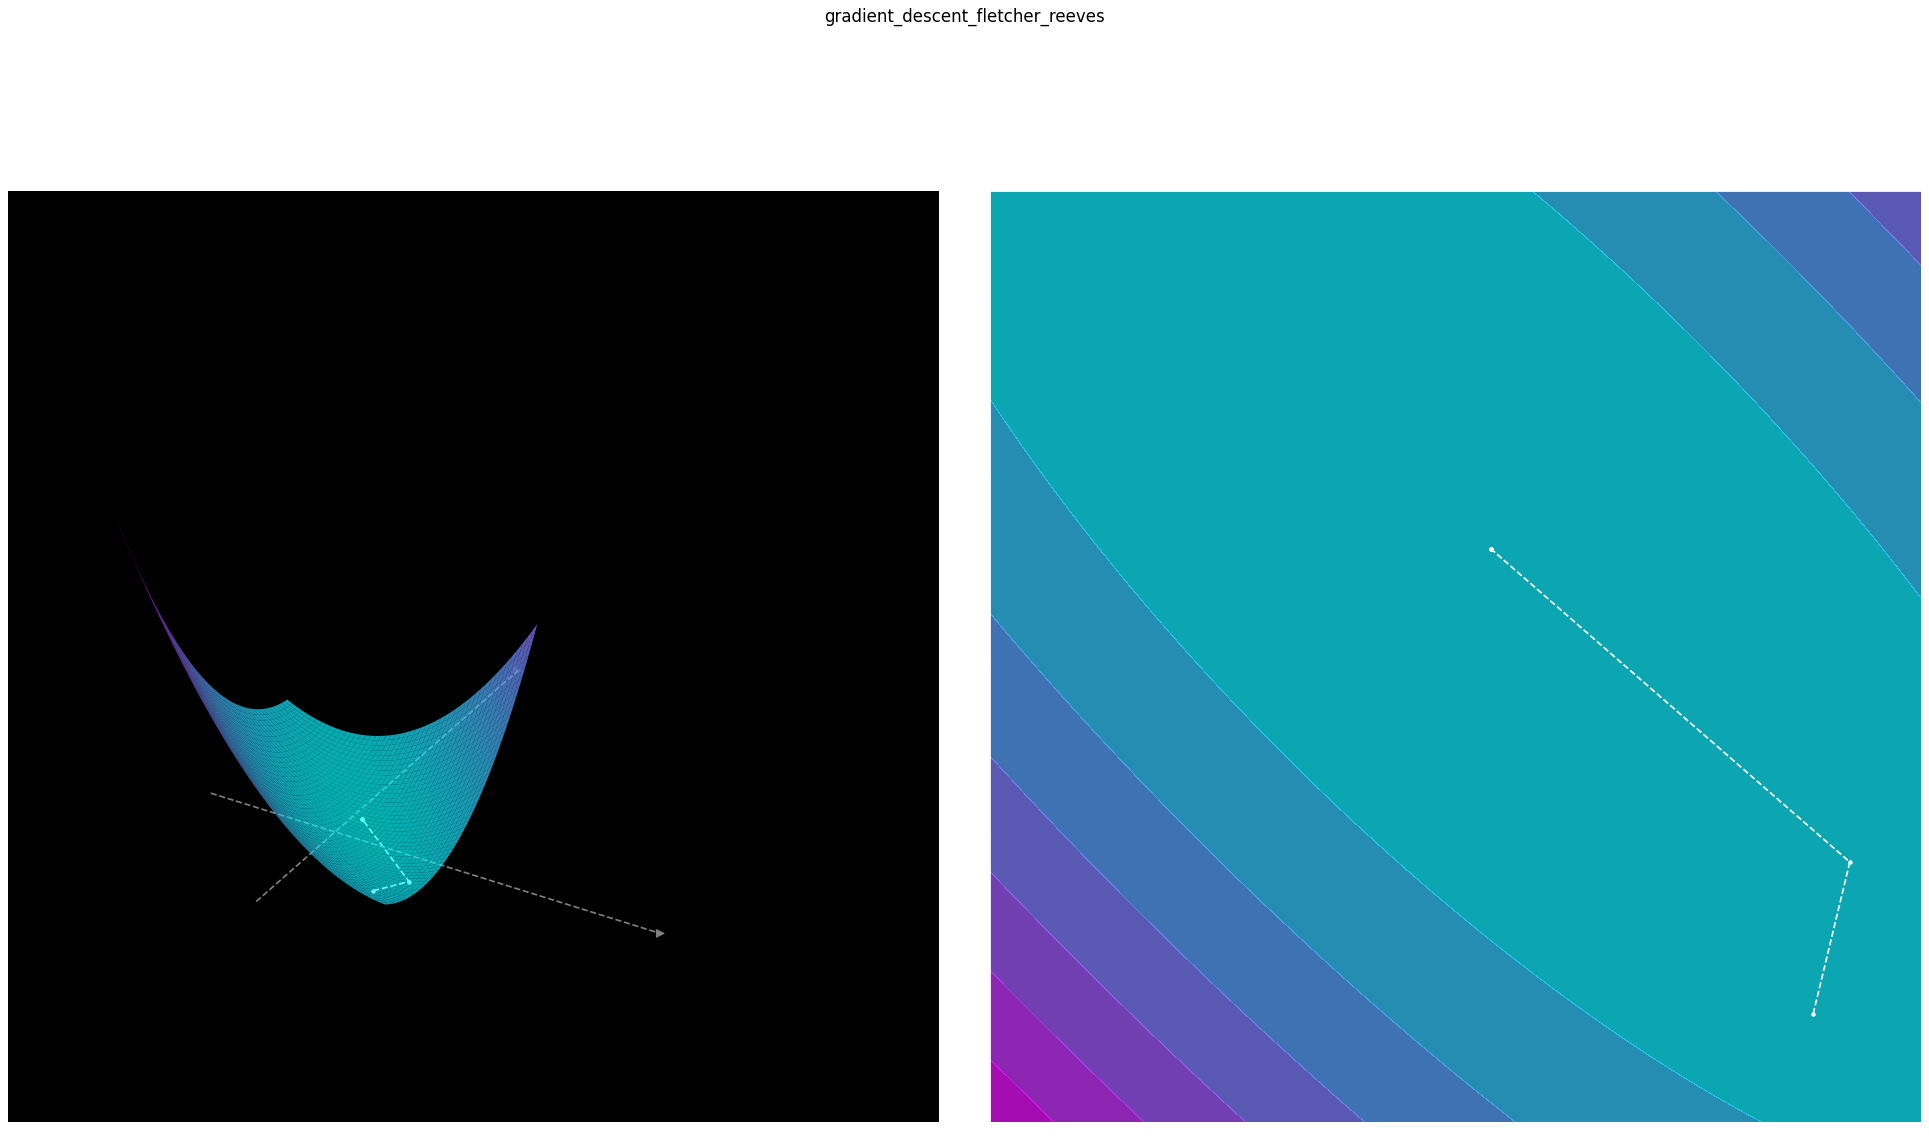

In [19]:
dummy = gradient_descent_fletcher_reeves(f2, golden_section_search, np.array([10, -10], dtype=float), save_data=True)

## 5. Analysis

In [20]:
Repository.visualize()

method_name,iterations,x0,xn,tolerance,learning_rate
gradient_descent_const_0,21,"[10.0, 10.0]","[0.00021886951760140752, 0.00021886951760140752]",0.0001,0.2000


method_name,iterations,x0,xn,tolerance,learning_rate
gradient_descent_const_1,55,"[10.0, 10.0]","[-4.726805463779934e-05, -4.726805463779934e-05]",0.0001,0.9000


method_name,iterations,x0,xn,tolerance,learning_rate
gradient_descent_const_2,377,"[10.0, 10.0]","[0.004922508184607827, 0.004922508184607827]",0.0001,0.0100


method_name,iterations,x0,xn,tolerance,eps,delta
gradient_descent_step_crushing_3,51,"[10.0, 10.0]","[0.9999641258280123, 2.999939601785985]",0.0001,0.1000,0.9500


method_name,iterations,x0,xn,tolerance,opt_method
gradient_descent_opt1d_4,40,"[10.0, -10.0]","[1.000206844894394, 2.9997056951682723]",0.0001,golden_section_search


method_name,iterations,x0,xn,tolerance,opt_method
gradient_descent_opt1d_5,40,"[10.0, -10.0]","[1.0002037344629982, 2.999709333334192]",0.0001,fibonacci_search


method_name,iterations,x0,xn,tolerance,opt_method
gradient_descent_fletcher_reeves_6,4,"[10.0, -10.0]","[0.999998439749567, 2.99999782451861]",0.0001,golden_section_search


method_name,iterations,x0,xn,tolerance,opt_method
gradient_descent_fletcher_reeves_7,4,"[10.0, -10.0]","[0.999998439749567, 2.99999782451861]",0.0001,golden_section_search
